In [1]:
!pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=48c4d51eb6cba5f55f6c33f6a2c0dc5ad4766a40bf98727e3da493320c9ab6cc
  Stored in directory: c:\users\yao\appdata\local\pip\cache\wheels\3f\e3\ec\8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
Successfully built termcolor
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0


In [2]:
import tensorflow as tf

In [4]:
import pandas as pd
import numpy as np
import os,sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import random
from collections import Counter, defaultdict
from tqdm import tqdm

In [87]:
path = os.getcwd()
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2014*","*csv"))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2015*","*csv")))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2016*","*csv")))
train_data = pd.DataFrame()
for f in files:
    try:
        if train_data.empty:
            train_data = pd.read_csv(f)
        else:
            train_data = pd.concat([train_data,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20140101-20141231\beijing_all_20141231.csv. Message is: Error tokenizing data. C error: Expected 3 fields in line 34, saw 5

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161231.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161231.csv. Message is: No columns to parse from file


In [88]:
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2017*","*csv"))
test_data = pd.DataFrame()
for f in files:
    try:
        if test_data.empty:
            test_data = pd.read_csv(f)
        else:
            test_data = pd.concat([test_data,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

In [89]:
train_data = train_data[~((train_data['type']=='PM2.5')&(train_data['门头沟']>2000))]

In [90]:
def preprocess(df):
    #convert date and hour columns into a Datetime index
    df['Datetime'] = pd.to_datetime(df['date'],format='%Y%m%d')+pd.to_timedelta(df['hour'].astype(int), unit='H')
    df = df.set_index('Datetime')
    df = df.drop(columns=['date','hour'])
    #remove AQI and all pollutants with suffix '_24h'
    pollutant = set(df.type)
    pollutant.remove('AQI')
    pollutant = [p for p in pollutant if '24h' not in p]
    df = df.loc[df['type'].isin(pollutant)]
    return df

In [91]:
train_data = preprocess(train_data)
test_data = preprocess(test_data)

In [92]:
train_data

,type,东四,天坛,官园,万寿西宫,奥体中心,农展馆,万柳,北部新区,植物园,...,密云水库,东高村,永乐店,榆垡,琉璃河,前门,永定门内,西直门北,南三环,东四环
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,PM2.5,35.0,32.0,45.0,66.0,20.0,31.0,57.0,22.0,17.0,...,NaN,21.0,110.0,90.0,136.0,75.0,66.0,35.0,84.0,45.0
2014-01-01 00:00:00,PM10,114.0,110.0,151.0,175.0,90.0,117.0,152.0,70.0,62.0,...,NaN,53.0,169.0,92.0,323.0,147.0,182.0,112.0,175.0,172.0
2014-01-01 01:00:00,PM2.5,66.0,56.0,57.0,72.0,43.0,58.0,68.0,22.0,25.0,...,14.0,14.0,116.0,122.0,181.0,87.0,68.0,56.0,85.0,46.0
2014-01-01 01:00:00,PM10,154.0,126.0,150.0,174.0,348.0,154.0,179.0,62.0,52.0,...,59.0,53.0,178.0,109.0,347.0,158.0,194.0,138.0,179.0,185.0
2014-01-01 02:00:00,PM2.5,70.0,53.0,57.0,80.0,79.0,68.0,81.0,21.0,15.0,...,21.0,23.0,133.0,135.0,235.0,92.0,76.0,59.0,93.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-29 08:00:00,CO,0.5,0.5,0.6,NaN,0.5,0.8,1.1,3.5,0.7,...,0.3,NaN,1.3,1.1,7.6,0.7,0.8,1.6,1.0,0.9
2016-12-29 09:00:00,SO2,7.0,4.0,11.0,10.0,8.0,9.0,13.0,12.0,9.0,...,2.0,NaN,24.0,3.0,NaN,6.0,9.0,11.0,11.0,12.0
2016-12-29 09:00:00,NO2,36.0,39.0,49.0,43.0,42.0,51.0,63.0,61.0,27.0,...,8.0,NaN,83.0,58.0,NaN,56.0,66.0,55.0,70.0,54.0


In [93]:
def process_one_location(df, location):#, take_log=True, take_diff=True, n_lag=3):
    subset = df.loc[:,['type',location]]
    subset.sort_values(by = ['Datetime'])
    subset = subset.pivot_table(values=location, index=[df.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

    return subset

In [94]:
df = process_one_location(train_data,'万柳' )

In [95]:
df = df.ffill().bfill()

In [96]:
test_df = process_one_location(test_data,'万柳' )

In [97]:
test_df = test_df.ffill().bfill()

In [175]:
test_df

,CO,NO2,O3,PM10,PM2.5,SO2
Datetime,,,,,,
2017-01-01 22:00:00,5.511257,3.276568,-0.884912,3.882042,4.639769,-0.613877
2017-01-01 23:00:00,6.474790,3.249347,-0.866913,3.990787,4.531622,-0.557317
2017-01-02 00:00:00,6.124414,3.058798,-0.866913,3.704097,4.315327,-0.613877
2017-01-02 01:00:00,6.299602,3.113240,-0.848913,3.931471,4.363392,-0.557317
2017-01-02 02:00:00,6.387196,3.113240,-0.866913,3.743640,4.303310,-0.557317
...,...,...,...,...,...,...
2017-04-29 19:00:00,-0.795506,-1.106064,1.077013,-0.408418,-0.419133,-0.840114
2017-04-29 20:00:00,-0.795506,-0.969958,0.717026,-0.092071,-0.467198,-0.783555
2017-04-29 21:00:00,-0.707912,-0.452753,0.285043,0.115532,-0.371067,-0.670436


In [101]:
column_indices = {name: i for i, name in enumerate(df.columns)}

In [102]:
column_indices

{'CO': 0, 'NO2': 1, 'O3': 2, 'PM10': 3, 'PM2.5': 4, 'SO2': 5}

In [103]:
n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):]

In [104]:
num_features = df.shape[1]

In [105]:
num_features

6

In [106]:
train_mean = train_df.mean()
train_std = train_df.std()

In [107]:
train_mean

CO         1.208175
NO2       66.632283
O3        55.163669
PM10     125.313385
PM2.5     81.880077
SO2       17.853666
dtype: float64

In [108]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

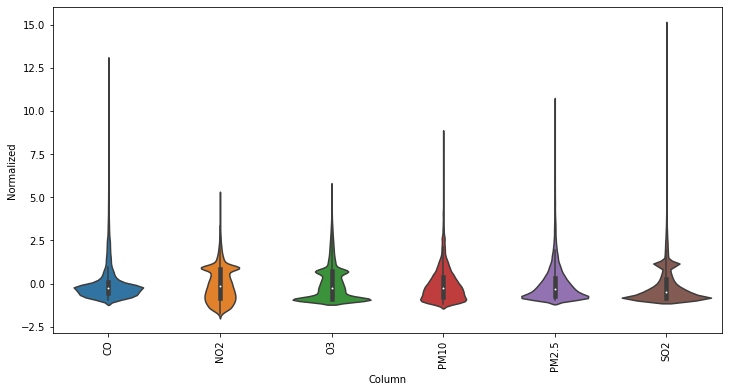

In [109]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [110]:
class PollutantGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [111]:
w1 = PollutantGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['PM2.5'])

In [112]:
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['PM2.5']

In [113]:
w2 = PollutantGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['PM2.5'])

In [114]:
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['PM2.5']

In [115]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

PollutantGenerator.split_window = split_window

In [116]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
Labels shape: (3, 1, 1)


In [117]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

PollutantGenerator.make_dataset = make_dataset

In [160]:
w2.train

<MapDataset element_spec=(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [118]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
    self._example = result
    return result

PollutantGenerator.train = train
PollutantGenerator.val = val
PollutantGenerator.test = test
PollutantGenerator.example = example

In [155]:
PollutantGenerator.train

In [119]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [162]:
for example_inputs, example_labels in w2.train.take(1):
    print(example_inputs)
    print(example_labels)
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

tf.Tensor(
[[[-0.53272426  0.2550016  -0.95690936 -0.53693414 -0.5873623
   -0.8966735 ]
  [-0.53272426  0.14611635 -0.95690936 -0.4183039  -0.5513131
   -0.8966735 ]
  [-0.53272426  0.06445239 -0.95690936 -0.53693414 -0.53929675
   -0.8966735 ]
  [-0.44513032  0.06445239 -0.95690936 -0.4183039  -0.5633295
   -0.8401141 ]
  [-0.3575364  -0.12609684 -0.93891    -0.38864633 -0.5152639
   -0.78355473]
  [-0.3575364  -0.18053949 -0.7589169  -0.06241319 -0.29896882
   -0.55731726]]

 [[-0.6203182   1.025365   -0.95690936  0.0661029  -0.6991148
   -0.64781225]
  [-0.6203182   0.943701   -0.95690936  0.0661029  -0.6870984
   -0.63650036]
  [-0.6203182   0.8429821  -0.95690936  0.0661029  -0.6666705
   -0.60256475]
  [-0.6203182   0.78309524 -0.95690936  0.0661029  -0.6522508
   -0.670436  ]
  [-0.44513032  0.65787715 -0.95690936  0.0661029  -0.63182294
   -0.59125286]
  [-0.44513032  0.64154434 -0.95690936  0.0661029  -0.50685245
   -0.4159188 ]]

 [[ 0.2556211   0.14611635 -0.95690936 -0.714

In [121]:
single_step_window = PollutantGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['PM2.5'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['PM2.5']

In [122]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [165]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [166]:
baseline = Baseline(label_index=column_indices['PM2.5'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.RootMeanSquaredError()])


In [167]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Tensor("baseline_3/strided_slice:0", shape=(None, 1), dtype=float32)
160/160 [==============================] - 0s 2ms/step - loss: 0.0430 - root_mean_squared_error: 0.2075


In [172]:
baseline.predict(single_step_window.val).shape

(5100, 1, 1)

In [174]:
baseline.predict(single_step_window.test).shape

(2546, 1, 1)

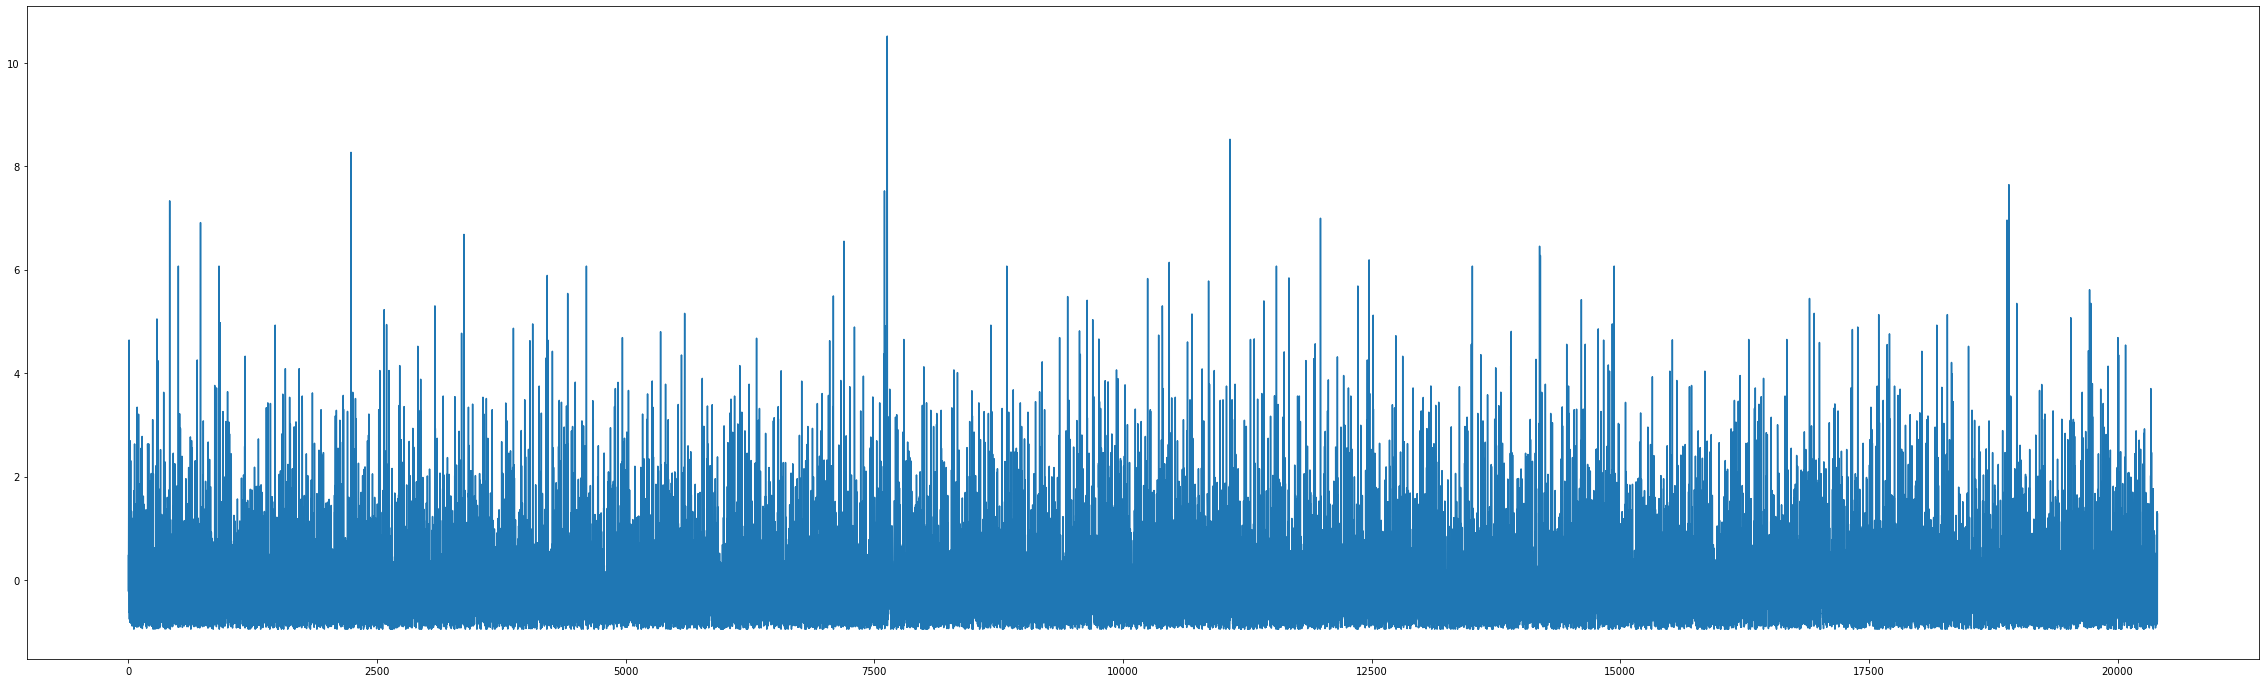

In [208]:
plt.figure(figsize=(40, 12))
plt.plot(baseline.predict(single_step_window.train).flatten())

In [209]:
train_df

,CO,NO2,O3,PM10,PM2.5,SO2
Datetime,,,,,,
2014-01-01 00:00:00,-0.182349,0.908313,0.717026,0.263820,-0.298969,1.139464
2014-01-01 01:00:00,-0.182349,0.908313,0.717026,0.530738,-0.166788,1.139464
2014-01-01 02:00:00,-0.182349,0.908313,0.717026,1.133775,-0.010575,1.139464
2014-01-01 03:00:00,-0.182349,0.908313,0.717026,1.025031,0.157654,1.139464
2014-01-01 04:00:00,-0.182349,0.908313,0.717026,0.797656,0.157654,1.139464
...,...,...,...,...,...,...
2016-05-24 22:00:00,-0.795506,-1.323835,0.933018,-0.635793,-0.827690,-0.896674
2016-05-24 23:00:00,-0.883100,-1.378278,1.059013,-0.635793,-0.863739,-0.896674
2016-05-25 00:00:00,-0.883100,-1.405499,1.041014,-1.080656,-0.947854,-0.896674


In [127]:
def plot(self, model=None, plot_col='PM2.5', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

PollutantGenerator.plot = plot

In [128]:
wide_window = PollutantGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['PM2.5'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['PM2.5']

In [129]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


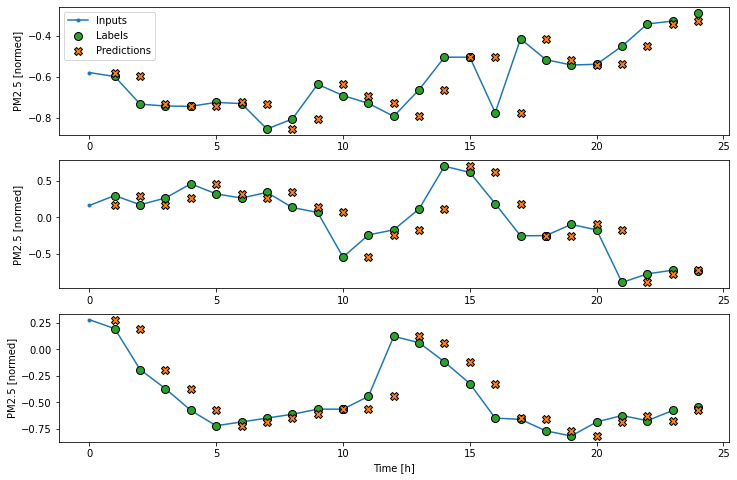

In [130]:
wide_window.plot(baseline)

In [132]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [133]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [134]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
638/638 [==============================] - 1s 1ms/step - loss: 1.2195 - mean_absolute_error: 0.7648 - val_loss: 0.5471 - val_mean_absolute_error: 0.5153
Epoch 2/20
638/638 [==============================] - 1s 1ms/step - loss: 0.5616 - mean_absolute_error: 0.5049 - val_loss: 0.2346 - val_mean_absolute_error: 0.3400
Epoch 3/20
638/638 [==============================] - 1s 2ms/step - loss: 0.3202 - mean_absolute_error: 0.3756 - val_loss: 0.1334 - val_mean_absolute_error: 0.2522
Epoch 4/20
638/638 [==============================] - 1s 1ms/step - loss: 0.1917 - mean_absolute_error: 0.2881 - val_loss: 0.0858 - val_mean_absolute_error: 0.1968
Epoch 5/20
638/638 [==============================] - 1s 1ms/step - loss: 0.1182 - mean_absolute_error: 0.2209 - val_loss: 0.0593 - val_mean_absolute_error: 0.1547
Epoch 6/20
638/638 [==============================] - 1s 1ms/step - loss: 0.0803 - mean_absolute_error: 0.1727 - val_loss: 0.0472 - val_mean_absolute_error: 0.1288
Epoch 7/20
638/6

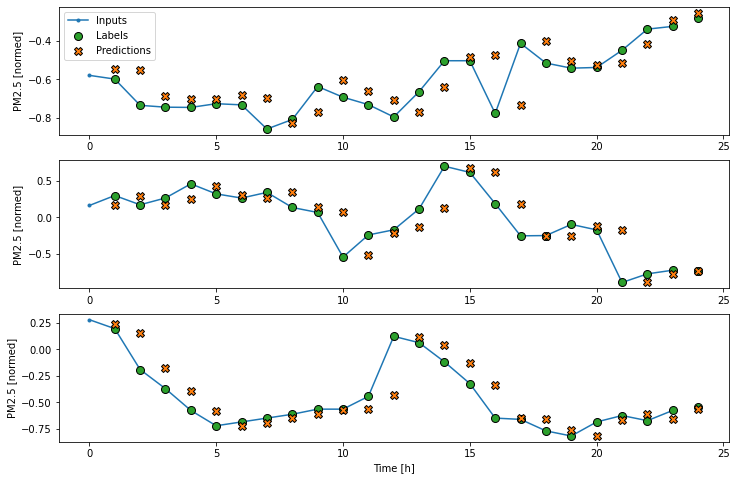

In [135]:
wide_window.plot(linear)

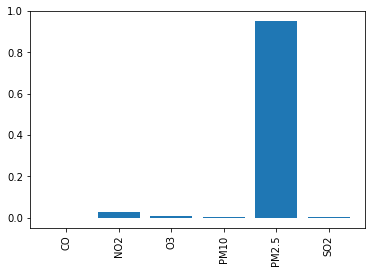

In [136]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [137]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
638/638 [==============================] - 2s 2ms/step - loss: 0.0856 - mean_absolute_error: 0.1612 - val_loss: 0.0431 - val_mean_absolute_error: 0.1169
Epoch 2/20
638/638 [==============================] - 1s 2ms/step - loss: 0.0603 - mean_absolute_error: 0.1343 - val_loss: 0.0442 - val_mean_absolute_error: 0.1215
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0445 - mean_absolute_error: 0.1159


In [183]:
CONV_WIDTH = 24
conv_window = PollutantGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['PM2.5'])

conv_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['PM2.5']

In [184]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [185]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 1, 1)


In [186]:
history = compile_and_fit(multi_step_dense, conv_window)

# IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
637/637 [==============================] - 2s 2ms/step - loss: 0.1869 - mean_absolute_error: 0.2652 - val_loss: 0.0801 - val_mean_absolute_error: 0.1821
Epoch 2/20
637/637 [==============================] - 1s 2ms/step - loss: 0.0934 - mean_absolute_error: 0.1880 - val_loss: 0.0800 - val_mean_absolute_error: 0.1778
Epoch 3/20
637/637 [==============================] - 1s 2ms/step - loss: 0.0771 - mean_absolute_error: 0.1687 - val_loss: 0.0612 - val_mean_absolute_error: 0.1526
Epoch 4/20
637/637 [==============================] - 1s 2ms/step - loss: 0.0704 - mean_absolute_error: 0.1601 - val_loss: 0.0538 - val_mean_absolute_error: 0.1430
Epoch 5/20
637/637 [==============================] - 1s 2ms/step - loss: 0.0663 - mean_absolute_error: 0.1543 - val_loss: 0.0617 - val_mean_absolute_error: 0.1500
Epoch 6/20
637/637 [==============================] - 1s 2ms/step - loss: 0.0636 - mean_absolute_error: 0.1493 - val_loss: 0.0496 - val_mean_absolute_error: 0.1343
Epoch 7/20
637/6

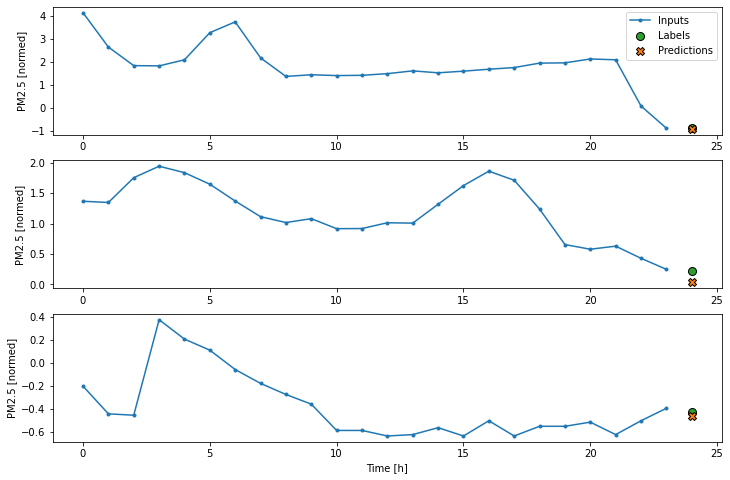

In [187]:
conv_window.plot(multi_step_dense)

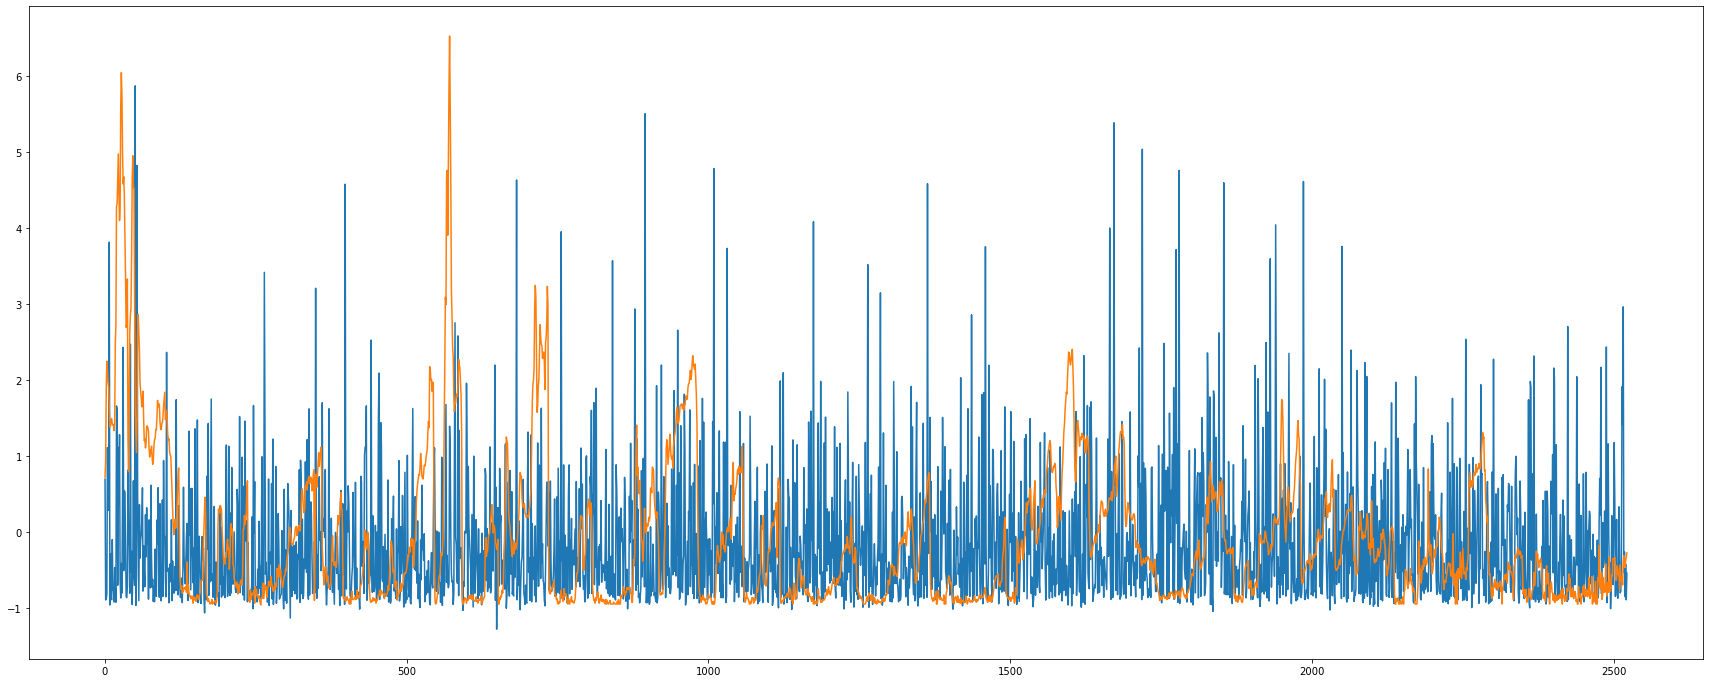

In [203]:
plt.figure(figsize=(30, 12))
plt.plot(multi_step_dense.predict(conv_window.test).flatten())
plt.plot(test_df['PM2.5'].values[24:])

In [197]:
test_df['PM2.5'].values[24:].shape

(2523,)

In [143]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [144]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 6)
Output shape: (32, 1, 1)


In [145]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
638/638 [==============================] - 2s 2ms/step - loss: 0.1428 - mean_absolute_error: 0.1991 - val_loss: 0.0555 - val_mean_absolute_error: 0.1390
Epoch 2/20
638/638 [==============================] - 1s 2ms/step - loss: 0.0610 - mean_absolute_error: 0.1378 - val_loss: 0.0454 - val_mean_absolute_error: 0.1252
Epoch 3/20
638/638 [==============================] - 1s 2ms/step - loss: 0.0569 - mean_absolute_error: 0.1318 - val_loss: 0.0417 - val_mean_absolute_error: 0.1159
Epoch 4/20
638/638 [==============================] - 1s 2ms/step - loss: 0.0553 - mean_absolute_error: 0.1287 - val_loss: 0.0395 - val_mean_absolute_error: 0.1115
Epoch 5/20
638/638 [==============================] - 1s 2ms/step - loss: 0.0543 - mean_absolute_error: 0.1281 - val_loss: 0.0402 - val_mean_absolute_error: 0.1121
Epoch 6/20
638/638 [==============================] - 1s 2ms/step - loss: 0.0543 - mean_absolute_error: 0.1278 - val_loss: 0.0390 - val_mean_absolute_error: 0.1102
Epoch 7/20
638/6

In [146]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 6)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [147]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = PollutantGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['PM2.5'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['PM2.5']

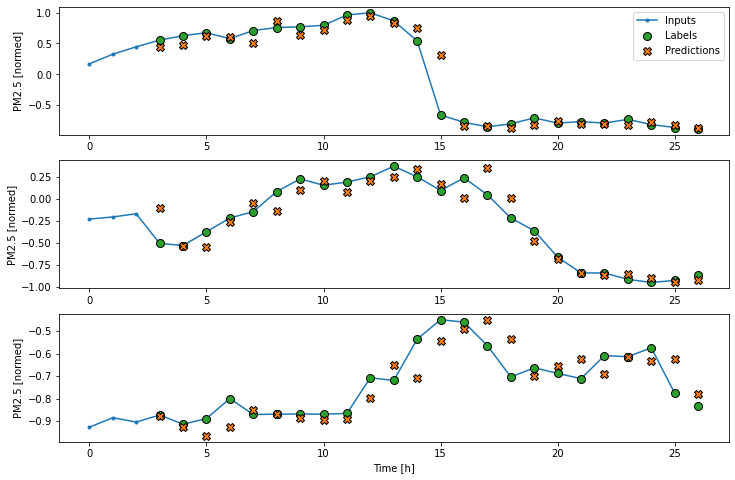

In [148]:
wide_conv_window.plot(conv_model)

In [149]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [182]:
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['PM2.5']

In [150]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
637/637 [==============================] - 9s 10ms/step - loss: 0.1273 - mean_absolute_error: 0.1998 - val_loss: 0.0444 - val_mean_absolute_error: 0.1224
Epoch 2/20
637/637 [==============================] - 6s 9ms/step - loss: 0.0527 - mean_absolute_error: 0.1253 - val_loss: 0.0388 - val_mean_absolute_error: 0.1096
Epoch 3/20
637/637 [==============================] - 6s 9ms/step - loss: 0.0492 - mean_absolute_error: 0.1201 - val_loss: 0.0381 - val_mean_absolute_error: 0.1069
Epoch 4/20
637/637 [==============================] - 6s 9ms/step - loss: 0.0475 - mean_absolute_error: 0.1187 - val_loss: 0.0376 - val_mean_absolute_error: 0.1066
Epoch 5/20
637/637 [==============================] - 6s 9ms/step - loss: 0.0462 - mean_absolute_error: 0.1180 - val_loss: 0.0378 - val_mean_absolute_error: 0.1072
Epoch 6/20
159/159 [==============================] - 1s 3ms/step - loss: 0.0381 - mean_absolute_error: 0.1075


In [181]:
lstm_model.predict(wide_window.test)[0]

array([[0.0621235 ],
       [0.36651507],
       [0.8091086 ],
       [0.739357  ],
       [0.93100476],
       [0.4571056 ],
       [0.27322006],
       [0.48487666],
       [0.5946059 ],
       [0.57566786],
       [0.47352302],
       [0.56452394],
       [0.61053693],
       [0.60602576],
       [0.44204167],
       [0.23304872],
       [0.3648909 ],
       [0.41279086],
       [0.53012824],
       [0.7240685 ],
       [0.6443696 ],
       [0.6301358 ],
       [0.5053968 ],
       [0.7322879 ]], dtype=float32)

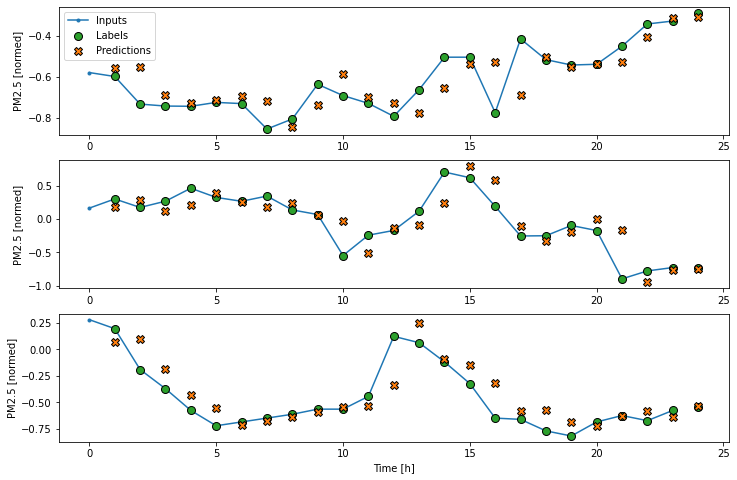

In [151]:
wide_window.plot(lstm_model)

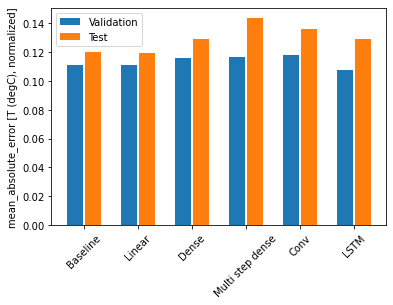

In [152]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()